In [1]:
import torch
import cv2
import os
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import random_split
from torchvision.models.segmentation import FCN_ResNet50_Weights, fcn_resnet50
from map_generation.dataset_lighting import LightingDataModule
from map_generation.masks.mask_dataset import SegmentationDataset
from map_generation.masks.model import SegmentationModule, SegmentationModel, Unet
from map_generation.train import train_model
from map_generation.masks.building_mask import BuildingMaskCreator


VECTOR_PATH = Path("../data/vector_tiles")
RASTER_PATH = Path("../data/tiles")
MASK_PATH = Path("../data/tiles")
TILE_ID = "35873_21926"
ZOOM = 16

# Building mask

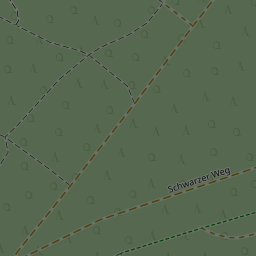

In [7]:
tile_id = "35170_21510"

mask_creator = BuildingMaskCreator(ZOOM, VECTOR_PATH / "Berlin, Germany", color=128)
mask = mask_creator.draw_mask(f"{tile_id}.mvt")
org_img = cv2.imread(f"../data/tiles/Berlin, Germany/{tile_id}.png")

mask_cv2 = cv2.cvtColor(np.array(mask), cv2.COLOR_GRAY2BGR)

img = cv2.addWeighted(mask_cv2, 0.5, org_img, 0.5, 0.0)

Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
done = []
vector_cities = set(os.listdir(VECTOR_PATH))
mask_creator = BuildingMaskCreator(zoom=ZOOM, path=VECTOR_PATH)
for city_dir in  sorted(os.listdir(RASTER_PATH)[8:]):
    print(city_dir)
    if city_dir not in vector_cities or city_dir in done:
        print("Skipping")
    else:
        rastser_path = RASTER_PATH / city_dir
        os.mkdir(rastser_path / "mask")
        for tile in tqdm(os.listdir(VECTOR_PATH / city_dir)):
            try:
                tile_path = os.path.join(city_dir, tile)
                mask_path = rastser_path / "mask" / tile.replace("mvt", "png")
                mask = mask_creator.draw_mask(tile_id=tile_path)
                mask.save(mask_path)
            except Exception as e:
                print(tile, e)
            
        done.append(city_dir)

# Model training

In [2]:
print("getting data")
ds = SegmentationDataset(RASTER_PATH, root_contrain_cities=True)
train_ds, test_ds = random_split(
    ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)


getting data


In [3]:
dataset = LightingDataModule(train_ds, test_ds, batch_size=16)
print("creating model")
weights = FCN_ResNet50_Weights.DEFAULT
fcn = fcn_resnet50(weights=weights)

model = SegmentationModule(segmentation_model=SegmentationModel(fcn, 21))
print("training...")
train_model(
    model=model, datamodule=dataset, epochs=20, name="segmentation_model", early_stop_metric="loss/val"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | SegmentationModel | 35.3 M
1 | loss     | BCEWithLogitsLoss | 0     
2 | accuracy | BinaryAccuracy    | 0     
-----------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.289   Total estimated model params size (MB)
/home/marcin/Documents/mgr/projekt_n_w/nw_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 5840: 'loss/val' reached 0.08596 (best 0.08596), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 11680: 'loss/val' reached 0.08411 (best 0.08411), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 17520: 'loss/val' reached 0.08373 (best 0.08373), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 23360: 'loss/val' reached 0.08292 (best 0.08292), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 29200: 'loss/val' reached 0.08178 (best 0.08178), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 35040: 'loss/val' was not in top 1
/home/marcin/Documents/mgr/projekt_n_w/nw_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
dataset = LightingDataModule(train_ds, test_ds, batch_size=128)

unet = Unet([16, 32, 64, 128, 256], 1)

model_unet = SegmentationModule(segmentation_model=SegmentationModel(unet, None))
train_model(
    model=model_unet, datamodule=dataset, epochs=100, name="segmentation_unet", early_stop_metric="loss/val", patience=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | SegmentationModel | 1.3 M 
1 | loss     | BCEWithLogitsLoss | 0     
2 | accuracy | BinaryAccuracy    | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.327     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 730: 'loss/val' reached 0.23397 (best 0.23397), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1460: 'loss/val' reached 0.21697 (best 0.21697), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2190: 'loss/val' reached 0.18625 (best 0.18625), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 2920: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 3650: 'loss/val' reached 0.16363 (best 0.16363), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 4380: 'loss/val' reached 0.15275 (best 0.15275), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 5110: 'loss/val' reached 0.14122 (best 0.14122), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 5840: 'loss/val' reached 0.13216 (best 0.13216), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 6570: 'loss/val' reached 0.12756 (best 0.12756), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 7300: 'loss/val' reached 0.12632 (best 0.12632), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 8030: 'loss/val' reached 0.11987 (best 0.11987), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 8760: 'loss/val' reached 0.11370 (best 0.11370), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 9490: 'loss/val' reached 0.10810 (best 0.10810), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 10220: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 10950: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 11680: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 12410: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 13140: 'loss/val' reached 0.09477 (best 0.09477), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 13870: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 14600: 'loss/val' reached 0.09442 (best 0.09442), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 15330: 'loss/val' reached 0.09254 (best 0.09254), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 16060: 'loss/val' reached 0.09040 (best 0.09040), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 16790: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 17520: 'loss/val' reached 0.08670 (best 0.08670), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 18250: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 18980: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 19710: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 20440: 'loss/val' reached 0.08425 (best 0.08425), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 21170: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 21900: 'loss/val' reached 0.08424 (best 0.08424), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 22630: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 23360: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 24090: 'loss/val' reached 0.07945 (best 0.07945), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 24820: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 25550: 'loss/val' reached 0.07943 (best 0.07943), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 26280: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 27010: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 27740: 'loss/val' reached 0.07711 (best 0.07711), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 28470: 'loss/val' reached 0.07650 (best 0.07650), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 29200: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 29930: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 30660: 'loss/val' reached 0.07598 (best 0.07598), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 31390: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 32120: 'loss/val' reached 0.07430 (best 0.07430), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 32850: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 33580: 'loss/val' reached 0.07333 (best 0.07333), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 34310: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 35040: 'loss/val' reached 0.07278 (best 0.07278), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 35770: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 36500: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 37230: 'loss/val' reached 0.07230 (best 0.07230), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 37960: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 38690: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 39420: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 40150: 'loss/val' reached 0.07105 (best 0.07105), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 40880: 'loss/val' reached 0.07088 (best 0.07088), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 41610: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 42340: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 43070: 'loss/val' reached 0.07082 (best 0.07082), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 43800: 'loss/val' reached 0.07056 (best 0.07056), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 44530: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 45260: 'loss/val' reached 0.06980 (best 0.06980), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 45990: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 46720: 'loss/val' reached 0.06937 (best 0.06937), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 47450: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 48180: 'loss/val' reached 0.06928 (best 0.06928), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 48910: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 49640: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 50370: 'loss/val' reached 0.06883 (best 0.06883), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 51100: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 51830: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 52560: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 53290: 'loss/val' reached 0.06855 (best 0.06855), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 54020: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 54750: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 55480: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 56210: 'loss/val' reached 0.06841 (best 0.06841), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 56940: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 57670: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 58400: 'loss/val' reached 0.06782 (best 0.06782), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 59130: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 59860: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 60590: 'loss/val' reached 0.06743 (best 0.06743), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 61320: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 62050: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 62780: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 63510: 'loss/val' reached 0.06722 (best 0.06722), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 64240: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 64970: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 65700: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 66430: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 67160: 'loss/val' reached 0.06668 (best 0.06668), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 67890: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 68620: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 69350: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 70080: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 70810: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 71540: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 72270: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 73000: 'loss/val' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


In [3]:
dataset = LightingDataModule(train_ds, test_ds, batch_size=128)
unet_dropout = Unet([16, 32, 64, 128, 256], 1, dropout=0.2)

model_unet = SegmentationModule(segmentation_model=SegmentationModel(unet_dropout, None))
train_model(
    model=model_unet, datamodule=dataset, epochs=100, name="segmentation_unet_drop_0.5", early_stop_metric="loss/val", patience=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: logs/segmentation_unet_drop_0.5
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | SegmentationModel | 1.3 M 
1 | loss     | BCEWithLogitsLoss | 0     
2 | accuracy | BinaryAccuracy    | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.327     Total estimated model params size (MB)
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 730: 'loss/val' reached 2.42186 (best 2.42186), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1460: 'loss/val' reached 2.39582 (best 2.39582), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2190: 'loss/val' reached 1.79085 (best 1.79085), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 2920: 'loss/val' reached 1.58738 (best 1.58738), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 3650: 'loss/val' reached 1.20964 (best 1.20964), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 4380: 'loss/val' reached 1.03404 (best 1.03404), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 5110: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 5840: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 6570: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 7300: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 8030: 'loss/val' reached 0.80091 (best 0.80091), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 8760: 'loss/val' reached 0.64887 (best 0.64887), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 9490: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 10220: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 10950: 'loss/val' reached 0.63718 (best 0.63718), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 11680: 'loss/val' reached 0.63678 (best 0.63678), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 12410: 'loss/val' reached 0.54593 (best 0.54593), saving model to '/home/marcin/Documents/mgr/projekt_n_w/own/workflow_raster/model/segmentation_unet_drop_0.5.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 13140: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 13870: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 14600: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 15330: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 16060: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 16790: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 17520: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 18250: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 18980: 'loss/val' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 19710: 'loss/val' was not in top 1
